In [85]:
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
from pycbc_analysis import *
from pycbc.types.timeseries import load_timeseries

%matplotlib notebook

def rw_cor(time, signal, template, sr=4096, dt=0.21, step_dur=0.01, renorm_val=0):
    """Calculate running window cross-correlation coefficient between
    two data sets.
    
    time: sample times
    signal: signal data
    template: model to compare with
    sr: sampling rate
    dt: window width in seconds
    step_dur: step duration in seconds
    
    Returns 1D array with CC coefficients and 1D array with sample times.
    """
    
    length = len(time)
    width = int(dt*sr)
    step = int(step_dur*sr)
    n = (length-width)/step+1
    
    result = np.zeros((2,n))
    
    for i in range(n):
        
        sig_avg = np.mean(signal[:width])
        tmp_avg = np.mean(template[:width])
        renorm = renorm_val#np.min(np.abs(signal[:width]))*renorm_val
        
        #if renorm > 0:
        #    numerator = np.sum((signal[:width]-sig_avg)*(template[:width]-tmp_avg))
        #    denominator = np.sqrt(np.sum((signal[:width]-sig_avg)**2)*np.sum((template[:width]-tmp_avg)**2))+renorm
        #    result[0,i] = numerator/denominator
        
        result[0,i] = np.corrcoef(signal[:width], template[:width])[0,1]
        
        result[1,i] = (time[0]+time[width])/2
        
        signal = np.roll(signal, -step)
        template = np.roll(template, -step)
        time = np.roll(time, -step)
    
    return result[0], result[1]

def kullback_leibler(dist, model, dx, cutoff=3):
    vals = np.zeros(len(dist))
    for i in range(len(dist)):
        if dist[i] < cutoff:
            continue
        elif dist[i] == 0:
            val_tmp = 0
        elif model[i] == 0:
            #val_tmp = 0
            i1=2
            smoothed_model = np.mean(model[i-i1:i+(i1+1)])
            while smoothed_model == 0:
                i1 = i1+1
                smoothed_model = np.mean(model[i-i1:i+(i1+1)])
            val_tmp = dist[i]*np.log(dist[i]/smoothed_model)
        else:
            val_tmp = dist[i]*np.log(dist[i]/model[i])
        vals[i] = val_tmp
    theta = np.sum(vals)
    return theta

def norm(array, dx):
    prod = np.dot(array,array)
    return 1./np.sqrt(prod*dx)

def spec_leak(t, WBPR, WBPTPL, TPL, renorm=0, dt=1./4096.):
    
    TPL_norm = norm(TPL, dt)
    WBPTPL_norm = norm(WBPTPL, dt)
    
    dTPL = (WBPTPL_norm*WBPTPL-TPL_norm*TPL)/WBPTPL_norm
    
    dCC, _ = rw_cor(t, WBPR, dTPL, renorm_val=renorm, dt=0.025, step_dur=0.001)
    
    return dCC

In [118]:
def rw_cor_tmp(time, signal, template, raw_template, sr=4096, dt=0.21, step_dur=0.01, renorm_val=0):
    """Calculate running window cross-correlation coefficient between
    two data sets.
    
    time: sample times
    signal: signal data
    template: model to compare with
    sr: sampling rate
    dt: window width in seconds
    step_dur: step duration in seconds
    
    Returns 1D array with CC coefficients and 1D array with sample times.
    """
    
    length = len(time)
    width = int(dt*sr)
    step = int(step_dur*sr)
    n = (length-width)/step+1
    
    result = np.zeros((3,n))
    
    for i in range(n):
        
        sig_avg = np.mean(signal[:width])
        tmp_avg = np.mean(template[:width])
        renorm = renorm_val#np.min(np.abs(signal[:width]))*renorm_val
        
        #if renorm > 0:
        #    numerator = np.sum((signal[:width]-sig_avg)*(template[:width]-tmp_avg))
        #    denominator = np.sqrt(np.sum((signal[:width]-sig_avg)**2)*np.sum((template[:width]-tmp_avg)**2))+renorm
        #    result[0,i] = numerator/denominator
        
        raw_norm = norm(raw_template[:width], 1./float(sr))
        tpl_norm = norm(template[:width], 1./float(sr))
    
        dtpl = (tpl_norm*template[:width]-raw_norm*raw_template[:width])/tpl_norm
        result[1,i] = np.corrcoef(signal[:width], dtpl)[0,1]
        
        result[0,i] = np.corrcoef(signal[:width], template[:width])[0,1]-result[2,i]
        
        result[2,i] = (time[0]+time[width])/2
        
        signal = np.roll(signal, -step)
        template = np.roll(template, -step)
        raw_template = np.roll(template, -step)
        time = np.roll(time, -step)
    
    return result[0], result[1], result[2]

In [138]:
sr = 16384
tpl = np.load('Templates/H_%sKHZ.npy' %(sr/1024))
dt = 1./(4*4096.)
t = np.arange(0,32, dt)
t_i = t_i = np.logical_and(t>=16.1, t<=16.435)
t = t[t_i]
tpl = tpl[t_i]

cc, pos = rw_cor(t, tpl, tpl, dt=0.025, step_dur=0.001)
cc_len = len(cc)
n = 1

In [124]:
directory = '/media/jacob/GRAS2BackupV2/Waveform_test/'

H_no = []
L_no = []

for H,L in zip(sorted(os.listdir(directory+'H_%sKHZ/' %(sr/1024))), sorted(os.listdir(directory+'L_%sKHZ/' %(sr/1024)))):
    
    Hn = H.split('_')
    Ln = L.split('_')
    
    H_no.append(Hn[1])
    L_no.append(Ln[1])

dupes = []

for x in H_no:
    if x not in dupes:
        if x in L_no:
            dupes.append(x)

In [157]:
psd_seg_len = 4
window_edge = 4
i = 0
pre_loaded_data = [0]*n

for fname in sorted(os.listdir(directory+'H_%sKHZ/' %(sr/1024))):
    
    fname = fname.split('_')
    
    if fname[1] not in dupes:
        continue
    
    if i>=n:
        break
    
    data_tmp = read_strain(directory, fname[1]+'_'+fname[2], window_edge, gwf=False, sample_rate=sr)
    pre_loaded_data[i] = estimate_psd(data_tmp, psd_seg_len, psd_window='blackman')
    
    print(i)
    
    i += 1

0


In [161]:
CC = {'H': {'CC': np.zeros((n, cc_len)), 'CCR': np.zeros((n, cc_len))}, 
      'L': {'CC': np.zeros((n, cc_len)), 'CCR': np.zeros((n, cc_len))},
      'P': np.zeros(cc_len)}

for loaded_data in pre_loaded_data:
    
    if i>=n:
        break
    
    print(i)
    
    
    data = matched_filtering(loaded_data, m1=20, m2=12, inj=True, tpl_type=3)
    
    times = data['H']['S'].sample_times-data['H']['S'].sample_times[0]
    
    t = times[t_i]
    
    HWBPR = data['H']['WBPR']._data[t_i]
    LWBPR = data['L']['WBPR']._data[t_i]
    HWBPS = data['H']['WBPSR']._data[t_i]
    LWBPS = data['L']['WBPSR']._data[t_i]
    HWBPTPL = data['H']['WBPTPL']._data[t_i]
    LWBPTPL = data['L']['WBPTPL']._data[t_i]
    HTPL = data['H']['TPL']._data[t_i]
    LTPL = data['L']['TPL']._data[t_i]
    
    renorm = 0
    CCH, CCH_leak, _ = rw_cor_tmp(t, HWBPR, HWBPTPL, HTPL, renorm_val=renorm, dt=0.025, step_dur=0.001)
    CCL, CCL_leak, _ = rw_cor_tmp(t, LWBPR, LWBPTPL, LTPL, renorm_val=renorm, dt=0.025, step_dur=0.001)
    CCRH, CCRH_leak, _ = rw_cor_tmp(t, HWBPS, HWBPTPL, HTPL, renorm_val=renorm, dt=0.025, step_dur=0.001)
    CCRL, CCRL_leak, CC['P'] = rw_cor_tmp(t, LWBPS, LWBPTPL, LTPL, renorm_val=renorm, dt=0.025, step_dur=0.001)

    CC['H']['CC'][i] = CCH#(CCH-spec_leak(t, HWBPR, HWBPTPL, HTPL, renorm))#[pos_i]
    CC['L']['CC'][i] = CCL#(CCL-spec_leak(t, LWBPR, LWBPTPL, LTPL, renorm))#[pos_i]
    CC['H']['CCR'][i] = CCRH#(CCRH-spec_leak(t, HWBPS, HWBPTPL, HTPL, renorm))#[pos_i]
    CC['L']['CCR'][i] = CCRL#(CCRL-spec_leak(t, LWBPS, LWBPTPL, LTPL, renorm))#[pos_i]
    
    i +=1

In [131]:
no_bins = {'H': np.zeros(len(CC['H']['CC'])), 'L': np.zeros(len(CC['L']['CC']))}

for i in range(len(CC['H']['CC'])):
    print('Histogram no.')
    print(i)
    binH = np.histogram_bin_edges(CC['H']['CC'][i], bins='doane', range=(-1,1))
    binL = np.histogram_bin_edges(CC['H']['CC'][i], bins='doane', range=(-1,1))
    no_bins['H'][i] = len(np.diff(binH))
    no_bins['L'][i] = len(np.diff(binL))

H_no = int(round(np.mean(no_bins['H'])))
L_no = int(round(np.mean(no_bins['L'])))

vals = {'H': {'CC': np.zeros((n, H_no)), 'CCR': np.zeros((n, H_no))}, 
        'L': {'CC': np.zeros((n, L_no)), 'CCR': np.zeros((n, H_no))}}
bins = {'H': {'CC': np.zeros((n, H_no+1)), 'CCR': np.zeros((n, H_no+1))},
        'L': {'CC': np.zeros((n, L_no+1)), 'CCR': np.zeros((n, H_no+1))}} 

for i in range(n):
    
    print('Hist no. %s' %(i))
        
    vals['H']['CC'][i],bins['H']['CC'][i] = np.histogram(CC['H']['CC'][i], H_no, range=(-1,1))
    vals['L']['CC'][i],bins['L']['CC'][i] = np.histogram(CC['L']['CC'][i], L_no, range=(-1,1))
    
    vals['H']['CCR'][i],bins['H']['CCR'][i] = np.histogram(CC['H']['CCR'][i], H_no, range=(-1,1))
    vals['L']['CCR'][i],bins['L']['CCR'][i] = np.histogram(CC['L']['CCR'][i], L_no, range=(-1,1))

Histogram no.
0
Histogram no.
1
Histogram no.
2
Histogram no.
3
Histogram no.
4
Histogram no.
5
Histogram no.
6
Histogram no.
7
Histogram no.
8
Histogram no.
9
Histogram no.
10
Histogram no.
11
Histogram no.
12
Histogram no.
13
Histogram no.
14
Histogram no.
15
Histogram no.
16
Histogram no.
17
Histogram no.
18
Histogram no.
19
Histogram no.
20
Histogram no.
21
Histogram no.
22
Histogram no.
23
Histogram no.
24
Histogram no.
25
Histogram no.
26
Histogram no.
27
Histogram no.
28
Histogram no.
29
Histogram no.
30
Histogram no.
31
Histogram no.
32
Histogram no.
33
Histogram no.
34
Histogram no.
35
Histogram no.
36
Histogram no.
37
Histogram no.
38
Histogram no.
39
Histogram no.
40
Histogram no.
41
Histogram no.
42
Histogram no.
43
Histogram no.
44
Histogram no.
45
Histogram no.
46
Histogram no.
47
Histogram no.
48
Histogram no.
49
Histogram no.
50
Histogram no.
51
Histogram no.
52
Histogram no.
53
Histogram no.
54
Histogram no.
55
Histogram no.
56
Histogram no.
57
Histogram no.
58
Histogr

Histogram no.
606
Histogram no.
607
Histogram no.
608
Histogram no.
609
Histogram no.
610
Histogram no.
611
Histogram no.
612
Histogram no.
613
Histogram no.
614
Histogram no.
615
Histogram no.
616
Histogram no.
617
Histogram no.
618
Histogram no.
619
Histogram no.
620
Histogram no.
621
Histogram no.
622
Histogram no.
623
Histogram no.
624
Histogram no.
625
Histogram no.
626
Histogram no.
627
Histogram no.
628
Histogram no.
629
Histogram no.
630
Histogram no.
631
Histogram no.
632
Histogram no.
633
Histogram no.
634
Histogram no.
635
Histogram no.
636
Histogram no.
637
Histogram no.
638
Histogram no.
639
Histogram no.
640
Histogram no.
641
Histogram no.
642
Histogram no.
643
Histogram no.
644
Histogram no.
645
Histogram no.
646
Histogram no.
647
Histogram no.
648
Histogram no.
649
Histogram no.
650
Histogram no.
651
Histogram no.
652
Histogram no.
653
Histogram no.
654
Histogram no.
655
Histogram no.
656
Histogram no.
657
Histogram no.
658
Histogram no.
659
Histogram no.
660
Histogram 

Hist no. 311
Hist no. 312
Hist no. 313
Hist no. 314
Hist no. 315
Hist no. 316
Hist no. 317
Hist no. 318
Hist no. 319
Hist no. 320
Hist no. 321
Hist no. 322
Hist no. 323
Hist no. 324
Hist no. 325
Hist no. 326
Hist no. 327
Hist no. 328
Hist no. 329
Hist no. 330
Hist no. 331
Hist no. 332
Hist no. 333
Hist no. 334
Hist no. 335
Hist no. 336
Hist no. 337
Hist no. 338
Hist no. 339
Hist no. 340
Hist no. 341
Hist no. 342
Hist no. 343
Hist no. 344
Hist no. 345
Hist no. 346
Hist no. 347
Hist no. 348
Hist no. 349
Hist no. 350
Hist no. 351
Hist no. 352
Hist no. 353
Hist no. 354
Hist no. 355
Hist no. 356
Hist no. 357
Hist no. 358
Hist no. 359
Hist no. 360
Hist no. 361
Hist no. 362
Hist no. 363
Hist no. 364
Hist no. 365
Hist no. 366
Hist no. 367
Hist no. 368
Hist no. 369
Hist no. 370
Hist no. 371
Hist no. 372
Hist no. 373
Hist no. 374
Hist no. 375
Hist no. 376
Hist no. 377
Hist no. 378
Hist no. 379
Hist no. 380
Hist no. 381
Hist no. 382
Hist no. 383
Hist no. 384
Hist no. 385
Hist no. 386
Hist no. 387

In [132]:
xH = (bins['H']['CCR'][0,:-1]+bins['H']['CCR'][0,1:])/2
xL = (bins['L']['CCR'][0,:-1]+bins['L']['CCR'][0,1:])/2
dH = xH[1]-xH[0]
dL = xL[1]-xL[0]

CCH_avg_dist = np.mean(vals['H']['CCR'], axis=0)
CCL_avg_dist = np.mean(vals['L']['CCR'], axis=0)

CCH_avg_dist = CCH_avg_dist*norm(CCH_avg_dist, dH)
CCL_avg_dist = CCL_avg_dist*norm(CCL_avg_dist, dL)

In [133]:
theta = {'H': {'CC': np.zeros(n), 'CCR': np.zeros(n)},
         'L': {'CC': np.zeros(n), 'CCR': np.zeros(n)}}

for i in range(n):
    
    theta['H']['CC'][i] = kullback_leibler(vals['H']['CC'][i]*norm(vals['H']['CC'][i], dH), CCH_avg_dist, dH, cutoff=0)
    theta['L']['CC'][i] = kullback_leibler(vals['L']['CC'][i]*norm(vals['L']['CC'][i], dL), CCL_avg_dist, dL, cutoff=0)
    theta['H']['CCR'][i] = kullback_leibler(vals['H']['CCR'][i]*norm(vals['H']['CCR'][i], dH), CCH_avg_dist, dH, cutoff=0)
    theta['L']['CCR'][i] = kullback_leibler(vals['L']['CCR'][i]*norm(vals['L']['CCR'][i], dL), CCL_avg_dist, dL, cutoff=0)

segment_no = np.arange(0,len(theta['H']['CC']),1)

where_are_NaNs = np.isnan(theta['H']['CC'])
theta['H']['CC'][where_are_NaNs] = 0

<IPython.core.display.Javascript object>


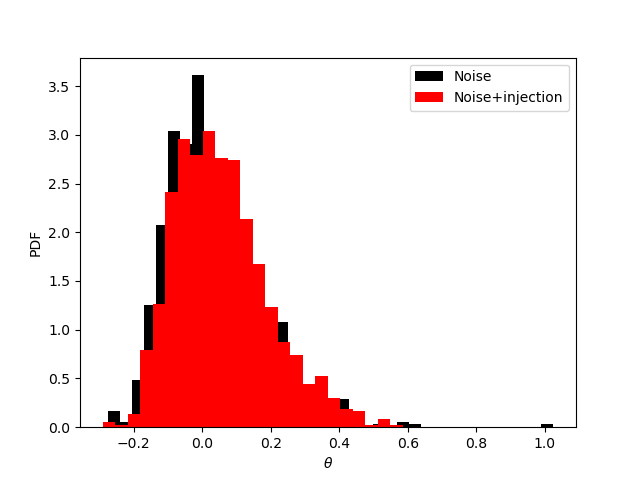

<IPython.core.display.Javascript object>


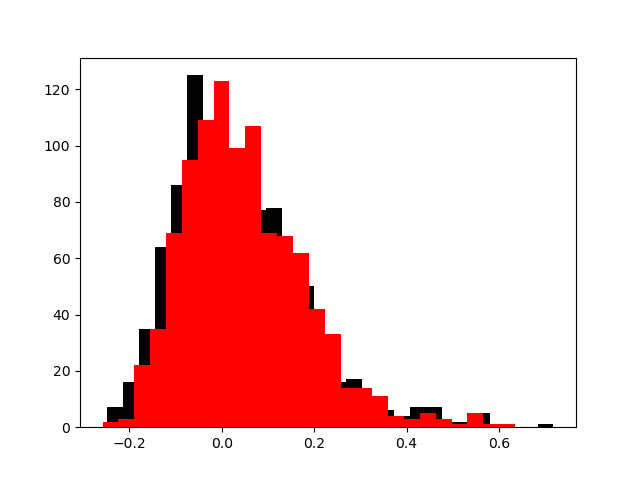

(array([  2.,   3.,  22.,  35.,  69.,  95., 109., 123.,  99., 107.,  69.,
         68.,  62.,  42.,  33.,  14.,  14.,  11.,   4.,   3.,   5.,   3.,
          1.,   5.,   1.,   1.]),
 array([-0.25820559, -0.22386522, -0.18952485, -0.15518448, -0.12084411,
        -0.08650374, -0.05216337, -0.017823  ,  0.01651737,  0.05085774,
         0.08519811,  0.11953849,  0.15387886,  0.18821923,  0.2225596 ,
         0.25689997,  0.29124034,  0.32558071,  0.35992108,  0.39426145,
         0.42860182,  0.46294219,  0.49728256,  0.53162293,  0.5659633 ,
         0.60030368,  0.63464405]),
 <a list of 26 Patch objects>)

In [134]:
#plt.figure()
#plt.plot(segment_no, theta['H']['CCR'], c='k')
#plt.plot(segment_no, theta['H']['CC'], c='r')

plt.figure()
plt.hist(theta['H']['CCR'], bins='auto', color='k', density=True, label='Noise')
plt.hist(theta['H']['CC'], bins='auto', color='r', density=True, label='Noise+injection')
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel('PDF')

plt.figure()
plt.hist(theta['L']['CCR'], bins='auto', color='k')
plt.hist(theta['L']['CC'], bins='auto', color='r')